In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import glob
import seaborn as sns
sns.set(style="dark")
plt.rcParams.update({'font.size': 8})



In [19]:
def reject_outliers_2(data, m=2.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    print(d)
    print(mdev)
    print(mdev if mdev else 1.)
    s = d / (mdev if mdev else 1.)
    return data[s < m]

def get_mode_insertion_data(env_path, data):
    data = []
    mode_insert_data = []
    min_size = np.inf
    for path in glob.glob(env_path + '*/'):
        data_set = pickle.load(open(path + 'reward_data.pkl', 'rb'))
        data_set = np.stack(data_set)
        if data_set[-1,0] < min_size:
            min_size = data_set[-1,0]
        data.append(data_set)
        try:
            mode_insert_set = pickle.load(open(path + 'mode_insert_data.pkl', 'rb'))
            mode_insert_data.append([data_set[:,0], mode_insert_set])
        except FileNotFoundError as err:
            pass
    x_samples = np.linspace(0, min_size)
    interp_data = []
    for data_set in data:
        _x = data_set[:,0]
        _y = data_set[:,1]
        interp_data.append(np.interp(x_samples, _x, _y))

def pull_max(d):
    _rew = None
    new_mean = []
    for m in d:
        if _rew is None:
            _rew = m
        else:
            if m > _rew:
                _rew = m
        new_mean.append(_rew)
    return new_mean

def process_data(env_path):
    data = []
    mode_insert_data = []
    min_size = np.inf
    for path in glob.glob(env_path + '*/'):
        data_set = pickle.load(open(path + 'reward_data.pkl', 'rb'))


        data_set = np.stack(data_set)
        if data_set[-1,0] < min_size:
            min_size = data_set[-1,0]
        data.append(data_set)
        has_mode_insert_data = False
        try:
            mode_insert_set = pickle.load(open(path + 'mode_insert_data.pkl', 'rb'))
            mode_insert_data.append([data_set[:-1,0], mode_insert_set])
            has_mode_insert_data = True
        except FileNotFoundError as err:
            pass
    x_samples = np.linspace(0, min_size)
    interp_data = []
    for data_set in data:
        _x = data_set[:,0]
        _y = pull_max(data_set[:,1])
        interp_data.append(np.interp(x_samples, _x, _y))
        
    mean = np.mean(interp_data, axis=0)
    std  = np.std(interp_data, axis=0)

    data_log = {'x' : x_samples, 'mean' : mean, 'std' : std, 
                'max' : np.max(interp_data, axis=0),
               'min' : np.min(interp_data, axis=0),
               '-std' : mean-std,
               '+std' : mean+std, 'data' : interp_data}
    
    if has_mode_insert_data:
        mi_interp_data = []
        for data_set in mode_insert_data:
            _x = data_set[0]
            _y = data_set[1]
            mi_interp_data.append(np.interp(x_samples, _x, _y))
        mi_mean = np.mean(mi_interp_data, axis=0)
        mi_max = np.max(mi_interp_data, axis=0)
        mi_min = np.min(mi_interp_data, axis=0)

        data_log.update({'mode_insert' : mi_mean,
                         'mi_min': mi_min,
                         'mi_max' : mi_max})

#     _data = np.stack(interp_data)
#     d = np.abs(_data - np.median(_data, axis=0, keepdims=True))
#     mdev = np.median(d, axis=0, keepdims=True)
#     s = d/(mdev if mdev.all() else 1)
#     idxs = s < 2
#     mean = []
#     std  = []
#     for i in range(idxs.shape[1]):
#         mean.append(np.mean(_data[idxs[:,i], i]))
#         std.append(np.std(_data[idxs[:,i], i]))
    

    return data_log

def plot_data(ax, log, label):
    ax.plot(log['x'], log['mean'], label=label)
    ax.fill_between(log['x'], 
                    log['min'], log['max'],
                    alpha=0.2)


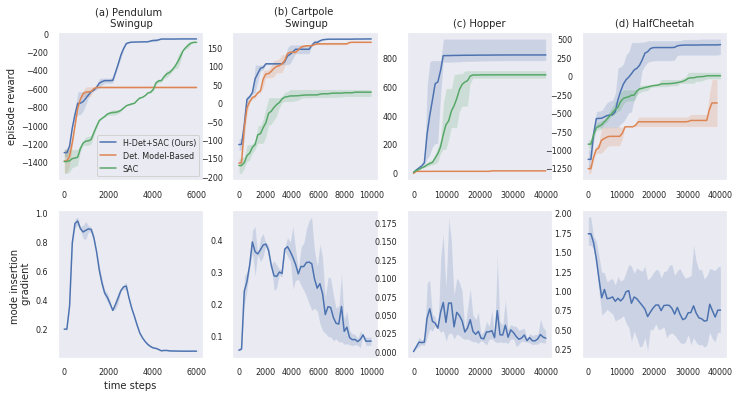

In [22]:
# fig, axs = plt.subplots(2, 4, figsize=(10,4))

fig, axs = plt.subplots(2, 4, figsize=(12,6))

env_list = ['PendulumEnv', 'InvertedPendulumSwingupBulletEnv', 'HopperBulletEnv', 'HalfCheetahBulletEnv']
names = {
    'PendulumEnv' : '(a) Pendulum \n Swingup',
    'InvertedPendulumSwingupBulletEnv' : '(b) Cartpole \n Swingup',
    'LunarLanderContinuousEnv' : 'Lundar\n Lander',
    'HopperBulletEnv' : '(c) Hopper',
    'HalfCheetahBulletEnv' : '(d) HalfCheetah'
}
# env_list = ['InvertedPendulumSwingupBulletEnv']#, 'InvertedPendulumSwingupBulletEnv', 'LunarLanderContinuousEnv', 'HopperBulletEnv']

for i,env in enumerate(env_list):
    hsac_data = process_data('./benchmarks/data/' + env + '/h_sac/')
    hdsac_data = process_data('./benchmarks/data/' + env + '/hd_sac/')
    sac_data = process_data('./benchmarks/data/'+ env +  '/sac/')

    stoch_model_data = process_data('./benchmarks/data/'+ env +  '/stoch_model_based_learning/')
    deter_model_data = process_data('./benchmarks/data/'+ env +  '/deter_model_based_learning/')


#     plot_data(axs[0,i], hsac_data, 'HStoc-SAC')
    plot_data(axs[0,i], hdsac_data, 'H-Det+SAC (Ours)')
#     plot_data(axs[0,i], stoch_model_data, 'Stoch-ModelBased')
    plot_data(axs[0,i], deter_model_data, 'Det. Model-Based')
    plot_data(axs[0,i], sac_data, 'SAC')
        

    axs[0,i].set_title(names[env], fontsize=10)
    
    axs[0,i].tick_params(axis='both', which='major', labelsize=8)
#     axs[i].tick_params(axis='both', which='minor', labelsize=10)
    axs[1,i].tick_params(axis='both', which='major', labelsize=8)

    
    axs[1,i].plot(hdsac_data['x'],hdsac_data['mode_insert'])
    axs[1,i].fill_between(hdsac_data['x'], 
                    hdsac_data['mi_min'], hdsac_data['mi_max'],
                    alpha=0.2)
    
    
axs[1,0].set_xlabel('time steps', fontsize=10)
axs[0,0].set_ylabel('episode reward', fontsize=10)
axs[0,0].legend(fontsize=8)

axs[1,0].set_ylabel('mode insertion \n gradient', fontsize=10)

# axs[0,2].set_ylim(-400, 150)
# axs[1,2].set_xlim(20, 1000)
# plt.tight_layout()

# plt.subplots_adjust(bottom=1, right=1, top=1)

plt.savefig('deterministic_benchmark_results.pdf')


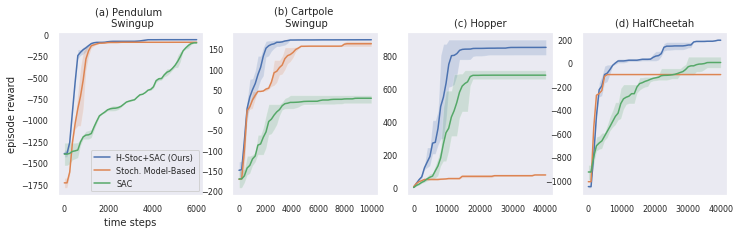

In [21]:
# fig, axs = plt.subplots(2, 4, figsize=(10,4))

fig, axs = plt.subplots(1, 4, figsize=(12,3))

env_list = ['PendulumEnv', 'InvertedPendulumSwingupBulletEnv', 'HopperBulletEnv', 'HalfCheetahBulletEnv']
names = {
    'PendulumEnv' : '(a) Pendulum \n Swingup',
    'InvertedPendulumSwingupBulletEnv' : '(b) Cartpole \n Swingup',
    'LunarLanderContinuousEnv' : 'Lundar\n Lander',
    'HopperBulletEnv' : '(c) Hopper',
    'HalfCheetahBulletEnv' : '(d) HalfCheetah'
}
# env_list = ['InvertedPendulumSwingupBulletEnv']#, 'InvertedPendulumSwingupBulletEnv', 'LunarLanderContinuousEnv', 'HopperBulletEnv']

for i,env in enumerate(env_list):
    hsac_data = process_data('./benchmarks/data/' + env + '/h_sac/')
    hdsac_data = process_data('./benchmarks/data/' + env + '/hd_sac/')
    sac_data = process_data('./benchmarks/data/'+ env +  '/sac/')

    stoch_model_data = process_data('./benchmarks/data/'+ env +  '/stoch_model_based_learning/')
    deter_model_data = process_data('./benchmarks/data/'+ env +  '/deter_model_based_learning/')


    plot_data(axs[i], hsac_data, 'H-Stoc+SAC (Ours)')
#     plot_data(axs[i], hdsac_data, 'H-Det+SAC (Ours)')
    plot_data(axs[i], stoch_model_data, 'Stoch. Model-Based')
#     plot_data(axs[i], deter_model_data, 'Det. Model-Based')
    plot_data(axs[i], sac_data, 'SAC')
        

    axs[i].set_title(names[env], fontsize=10)
    
    axs[i].tick_params(axis='both', which='major', labelsize=8)
    
    
axs[0].set_xlabel('time steps', fontsize=10)
axs[0].set_ylabel('episode reward', fontsize=10)
axs[0].legend(fontsize=8)

# axs[0,2].set_ylim(-400, 150)
# axs[1,2].set_xlim(20, 1000)
# plt.tight_layout()

# plt.subplots_adjust(bottom=1, right=1, top=1)

plt.savefig('stochastic_benchmark_results.pdf')


In [10]:
_rew = None
new_mean = []
for m in sac_data['mean']:
    if _rew is None:
        _rew = m
    else:
        if m > _rew:
            _rew = m
    new_mean.append(_rew)

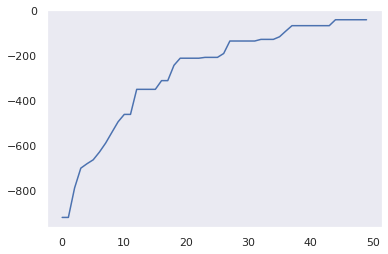

In [11]:
plt.plot(new_mean)

In [256]:
plt.plot(np.mean(hdsac_data['mode_insert'],axis=0)[:10])


TypeError: unsupported operand type(s) for /: 'list' and 'int'

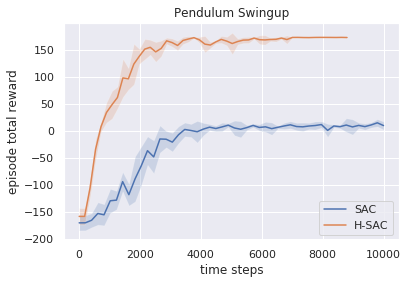

In [11]:
# hddpg_data = process_data('./benchmarks/data/InvertedPendulumSwingupBulletEnv/h_ddpg/')
# ddpg_data = process_data('./benchmarks/data/InvertedPendulumSwingupBulletEnv/ddpg/')

# hlt_data = process_data('./benchmarks/data/InvertedPendulumSwingupBulletEnv/hlt_skill/')


hsac_data = process_data('./benchmarks/data/InvertedPendulumSwingupBulletEnv/h_sac/')
sac_data = process_data('./benchmarks/data/InvertedPendulumSwingupBulletEnv/sac/')

# plot_data(hlt_data, 'HLT')
# plot_data(hddpg_data, 'H-DDPG')

plot_data(sac_data, 'SAC')
plot_data(hsac_data, 'H-SAC')

plt.xlabel('time steps')
plt.ylabel('episode total reward')
plt.title('Pendulum Swingup')

plt.legend()

(-400, 200)

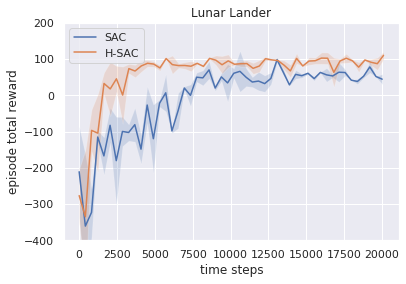

In [5]:
hddpg_data = process_data('./benchmarks/data/LunarLanderContinuousEnv/h_ddpg/')
ddpg_data = process_data('./benchmarks/data/LunarLanderContinuousEnv/ddpg/')

hsac_data = process_data('./benchmarks/data/LunarLanderContinuousEnv/h_sac/')
# hsac_data = process_data('./benchmarks/data/LunarLanderContinuousEnv/h_ddpg/')

sac_data = process_data('./benchmarks/data/LunarLanderContinuousEnv/sac/')

# plot_data(ddpg_data, 'DDPG')
# plot_data(hddpg_data, 'H-DDPG')

plot_data(sac_data, 'SAC')
plot_data(hsac_data, 'H-SAC')


plt.xlabel('time steps')
plt.ylabel('episode total reward')
plt.title('Lunar Lander')

plt.legend()
plt.ylim(-400, 200)

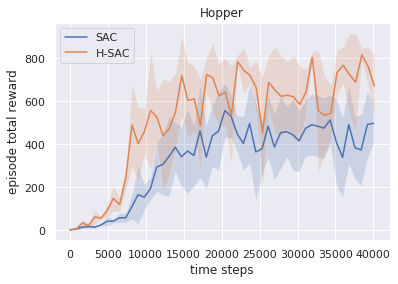

In [12]:
hsac_data = process_data('./benchmarks/data/HopperBulletEnv/h_sac/')
sac_data = process_data('./benchmarks/data/HopperBulletEnv/sac/')
hddpg_data = process_data('./benchmarks/data/HopperBulletEnv/h_ddpg/')
ddpg_data = process_data('./benchmarks/data/HopperBulletEnv/ddpg/')

# plot_data(ddpg_data, 'DDPG')
# plot_data(hddpg_data, 'H-DDPG')

plot_data(sac_data, 'SAC')

plot_data(hsac_data, 'H-SAC')

plt.xlabel('time steps')
plt.ylabel('episode total reward')
plt.title('Hopper')

plt.legend()


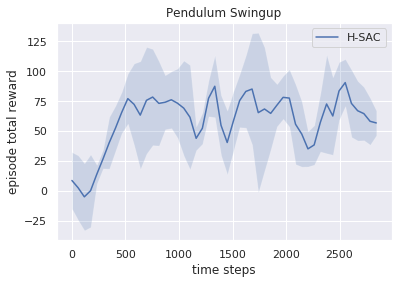

In [7]:
hsac_data = process_data('./benchmarks/data/KukaEnv/h_sac/')
# sac_data = process_data('./benchmarks/data/HopperBulletEnv/sac/')

# plot_data(ddpg_data, 'DDPG')
# plot_data(hddpg_data, 'H-DDPG')

# plot_data(sac_data, 'SAC')
plot_data(hsac_data, 'H-SAC')

plt.xlabel('time steps')
plt.ylabel('episode total reward')
plt.title('Pendulum Swingup')

plt.legend()

In [6]:
import torch

In [7]:
x = torch.randn(10,2, requires_grad=True)

In [16]:
y = x.detach()

In [17]:
y = y + 1.0

In [18]:
x

tensor([[ 0.8698,  0.7042],
        [ 0.1862,  0.6252],
        [ 0.7500,  0.6729],
        [ 1.8120,  0.9259],
        [ 0.7050,  0.0501],
        [-1.4075,  0.9652],
        [-0.2444, -0.2697],
        [ 0.6577, -0.5374],
        [ 0.0069, -0.0144],
        [-0.9087,  2.0609]], requires_grad=True)

In [19]:
y

tensor([[ 1.8698,  1.7042],
        [ 1.1862,  1.6252],
        [ 1.7500,  1.6729],
        [ 2.8120,  1.9259],
        [ 1.7050,  1.0501],
        [-0.4075,  1.9652],
        [ 0.7556,  0.7303],
        [ 1.6577,  0.4626],
        [ 1.0069,  0.9856],
        [ 0.0913,  3.0609]])

In [50]:
import torch

In [62]:
x = torch.rand(1,5) - 0.5

In [63]:
torch.norm(x)

tensor(0.6002)

In [64]:
xm = torch.norm(x, 2)

In [57]:
torch.norm(x, 'fro')

tensor(1.2903)

In [65]:
x / xm

tensor([[ 0.5100,  0.1584, -0.4380, -0.4580, -0.5596]])

In [66]:
x

tensor([[ 0.3061,  0.0951, -0.2629, -0.2749, -0.3359]])